# Analyzing word and document frequency: tf-idf

A central question in text mining and natural language processing is how to quantify what a document is about. Can we do this by looking at the words that make up the document? 

One measure of how important a word may be is its term frequency (tf). 

This is how frequently a word occurs in a document - as we saw in Lab 2. However, there are words in a document that occur many times but may not be important. In English these words are most often things like “the”, “is”, “of”, and so forth. We might take the approach of adding words like these to a list of stop words and removing them before analysis, but it is possible that some of these words might be more important in some documents than others. A list of stop words is not a very sophisticated approach to adjusting term frequency for commonly used words.

Another approach is to look at a term’s inverse document frequency (idf), which decreases the weight for commonly used words and increases the weight for words that are not used very much in a collection of documents. This can be combined with term frequency to calculate a term’s tf-idf (the two quantities multiplied together), the frequency of a term adjusted for how rarely it is used.

The tf-idf statistic is intended to measure how important a word is to a document in a collection (or corpus) of documents, for example, to one novel in a collection of novels or to one website in a collection of websites.

### Preparing data

In [1]:
import requests
import string
import pandas as pd

# Jane Eyre
book_url = 'https://www.gutenberg.org/files/1260/1260-0.txt'
response = requests.get(book_url)
bronte1 = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
bronte1 = ''.join(c for c in bronte1 if c in allowed_chars)

# Wuthering Heights
book_url = 'https://www.gutenberg.org/cache/epub/768/pg768.txt'
response = requests.get(book_url)
bronte2 = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
bronte2 = ''.join(c for c in bronte2 if c in allowed_chars)

# Vilette
book_url = 'https://www.gutenberg.org/files/9182/9182-0.txt'
response = requests.get(book_url)
bronte3 = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
bronte3 = ''.join(c for c in bronte3 if c in allowed_chars)

# Agnes Gray
book_url = 'https://www.gutenberg.org/files/767/767-0.txt'
response = requests.get(book_url)
bronte4 = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
bronte4 = ''.join(c for c in bronte4 if c in allowed_chars)

# Create our dataframes
bronte1_lines = bronte1.splitlines()

bronte1_df = pd.DataFrame({
    "line": bronte1_lines,
    "line_number": list(range(len(bronte1_lines)))
})

bronte2_lines = bronte2.splitlines()

bronte2_df = pd.DataFrame({
    "line": bronte2_lines,
    "line_number": list(range(len(bronte2_lines)))
})

bronte3_lines = bronte3.splitlines()

bronte3_df = pd.DataFrame({
    "line": bronte3_lines,
    "line_number": list(range(len(bronte3_lines)))
})

bronte4_lines = bronte4.splitlines()

bronte4_df = pd.DataFrame({
    "line": bronte4_lines,
    "line_number": list(range(len(bronte4_lines)))
})

# We’ll want to know which content comes from which book
bronte1_df = bronte1_df.assign(book = 'Jane Eyre')
bronte2_df = bronte2_df.assign(book = 'Wuthering Heights')
bronte3_df = bronte3_df.assign(book = 'Vilette')
bronte4_df = bronte4_df.assign(book = 'Agnes Grey')

# Finally, we concatenate the books into one dataframe
books = [bronte1_df, bronte2_df, bronte3_df, bronte4_df]
bronte_books_df = pd.concat(books)
bronte_books_df.head()

,line,line_number,book
0,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre
1,,1,Jane Eyre
2,This eBook is for the use of anyone anywhere i...,2,Jane Eyre
3,most other parts of the world at no cost and w...,3,Jane Eyre
4,whatsoever You may copy it give it away or reu...,4,Jane Eyre


In [2]:
# We split the data into words
# We first split the text column into a list of words
bronte_books_df['word'] = bronte_books_df['line'].str.split()

# Explode the words column to create a new row for each word (this creates a separate row for each word from the newly created words list)
bronte_books_df = bronte_books_df.explode('word')

# Reset the index of the dataframe (we want to index each word now)
bronte_books_df = bronte_books_df.reset_index(drop=True)
bronte_books_df.head()

,line,line_number,book,word
0,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,The
1,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,Project
2,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,Gutenberg
3,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,eBook
4,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,of


In [3]:
# For our investigations the line & line_number columns will not be necessary, so we will remove them
bronte_books_df = bronte_books_df[['book', 'word']]
bronte_books_df

,book,word
0,Jane Eyre,The
1,Jane Eyre,Project
2,Jane Eyre,Gutenberg
3,Jane Eyre,eBook
4,Jane Eyre,of
...,...,...
585198,Agnes Grey,about
585199,Agnes Grey,new
585200,Agnes Grey,eBooks
585201,Agnes Grey,NaN


### Word counting revisited

In [4]:
# Let's count the occurrences of each word - this is a prerequisite for finding term frequency
count_df = bronte_books_df.groupby('word')['word'].count() # Group by word column, then only keep the word column and perform the counting

# Let's sort by term frequency
count_df_sorted = count_df.sort_values(ascending=False)

pd.set_option('display.max_rows', 10) # You can change the max number of rows that get displayed
count_df_sorted.head(10)

word
the    22423
and    19617
I      18439
to     15784
of     13370
a      12297
in      8104
was     7444
you     6431
her     5981
Name: word, dtype: int64

In [5]:
# The .size() method functions similary, but differs slightly in output format
# .size() also counts null values, which .count() does not
bronte_books_df.groupby(['word']).size().sort_values(ascending=False).reset_index(name='count')

,word,count
0,the,22423
1,and,19617
2,I,18439
3,to,15784
4,of,13370
...,...,...
30119,glovessuch,1
30120,gloveless,1
30121,glossily,1
30122,glossiest,1


In [6]:
# Groupby allows grouping based on multiple columns
bronte_books_df.groupby(['word', 'book']).size().sort_values(ascending=False).reset_index(name='count')

,word,book,count
0,the,Vilette,7894
1,the,Jane Eyre,7501
2,I,Jane Eyre,7009
3,and,Jane Eyre,6328
4,and,Vilette,6163
...,...,...,...
54097,nolet,Jane Eyre,1
54098,noit,Jane Eyre,1
54099,noisy,Wuthering Heights,1
54100,counting,Agnes Grey,1


### Aggregate
One useful and elegant way of counting/aggregating data in pandas is by using the .agg() method.


In [7]:
# We group our data by words, then we aggregate and can decide what information we want to display for each column

# setting 'first' for the book column means that in the new dataframe we will display the first book on which each word occurs (in the book column)
# setting 'count' for the word column means that in the new dataframe we will display the count of given word (in the word column)
count_df = bronte_books_df.groupby('word').agg({'book': 'first', 'word': 'count'}) 
count_df

,book,word
word,,
1,Jane Eyre,9
10,Vilette,1
12,Vilette,1
1260,Jane Eyre,1
13th,Jane Eyre,1
...,...,...
zigzag,Jane Eyre,2
zigzags,Vilette,1
zle,Vilette,1


In [8]:
# Because we used groupby, the 'word' keyword has become both an index and a column name
# To get rid of any naming problems down the line, we will rename the column name 'word' to 'count'
count_df = count_df.rename(columns={'word': 'count'})

# Sorting values based on count column
count_df.sort_values('count', ascending=False)

,book,count
word,,
the,Jane Eyre,22423
and,Jane Eyre,19617
I,Jane Eyre,18439
to,Jane Eyre,15784
of,Jane Eyre,13370
...,...,...
glovessuch,Vilette,1
gloveless,Agnes Grey,1
glossily,Jane Eyre,1


### Merging Dataframes

What we want next is to have a dataframe in which we know how many times each word appears per book and how many times it appears in all of the books.

It is sometimes very useful to merge together two dataframes and this is what we're going to do to get our desired dataframe.

In [9]:
count_df_1 = bronte_books_df.groupby(['word', 'book']).size().sort_values(ascending=False).reset_index(name='count') # How many appearances each word has in each book
count_df_1

,word,book,count
0,the,Vilette,7894
1,the,Jane Eyre,7501
2,I,Jane Eyre,7009
3,and,Jane Eyre,6328
4,and,Vilette,6163
...,...,...,...
54097,nolet,Jane Eyre,1
54098,noit,Jane Eyre,1
54099,noisy,Wuthering Heights,1
54100,counting,Agnes Grey,1


In [10]:
count_df_2 = bronte_books_df.groupby(['book']).size().sort_values(ascending=False).reset_index(name='count') # How many words each book has
count_df_2

,book,count
0,Vilette,199315
1,Jane Eyre,192766
2,Wuthering Heights,121114
3,Agnes Grey,72008


In [11]:
book_words = count_df_1.merge(count_df_2, on='book')
book_words.head(10)

,word,book,count_x,count_y
0,the,Vilette,7894,199315
1,and,Vilette,6163,199315
2,I,Vilette,5762,199315
3,of,Vilette,4924,199315
4,to,Vilette,4732,199315
5,a,Vilette,4406,199315
6,in,Vilette,2980,199315
7,was,Vilette,2836,199315
8,her,Vilette,2071,199315
9,it,Vilette,1905,199315


In [12]:
book_words = book_words.rename(columns={'count_x': 'word_appearances_in_book', 'count_y': 'book_total_word_count'}) # Give more meaningful names
book_words.head(10)

,word,book,word_appearances_in_book,book_total_word_count
0,the,Vilette,7894,199315
1,and,Vilette,6163,199315
2,I,Vilette,5762,199315
3,of,Vilette,4924,199315
4,to,Vilette,4732,199315
5,a,Vilette,4406,199315
6,in,Vilette,2980,199315
7,was,Vilette,2836,199315
8,her,Vilette,2071,199315
9,it,Vilette,1905,199315


### Exercise 1 

1. Add a **tf** (term frequency) column to your dataframe.
2. Add a **rank** column to your dataframe.
3. Draw the rank vs term-frequency plot by uncommenting the code below 

Term frequency says how frequently a given word appears in a book. The formula for calculating it is 
    
    term_frequency = word_appearances_in_book / book_total_word_count

E.g. If a word appears 30 times in a book with 1000 words, then the term frequency of that word will be 0.03. (or 3%).

The rank of a word will tell you where your word places itself in the frequency rankings **of your book**.

i.e. The most common word in your book will have rank 1.
E.g. If the entire text of your book is: "he ate chips, ate pudding and he ate spinach", then you would have:

    ate - rank 1 (count = 3)
    he - rank 2 (count = 2)
    chips - rank 3 (count = 1)
    pudding - rank 3 (count = 1)
    and - rank 3 (count = 1)
    spinach - rank 3 (count = 1)


Hint: you can use the pandas .rank(method='dense', ascending=False) method for obtaining your word rank. 

In [13]:
# Write your code below
#1 

print('\n1')
book_words['term_frequency'] = book_words['word_appearances_in_book'].div(book_words['book_total_word_count'])
book_words.dropna(subset = ['term_frequency'], inplace=True)
book_words.head()



1


,word,book,word_appearances_in_book,book_total_word_count,term_frequency
0,the,Vilette,7894,199315,0.039606
1,and,Vilette,6163,199315,0.030921
2,I,Vilette,5762,199315,0.028909
3,of,Vilette,4924,199315,0.024705
4,to,Vilette,4732,199315,0.023741


In [14]:
print('\n2')
rank_df = book_words['word_appearances_in_book'].rank(method='dense', ascending=False)
book_words_df = pd.concat([rank_df.rename('rank'), book_words], axis=1).reset_index(drop=True)
book_words_df[['word', 'book', 'word_appearances_in_book','book_total_word_count', 'term_frequency', 'rank']]


2


,word,book,word_appearances_in_book,book_total_word_count,term_frequency,rank
0,the,Vilette,7894,199315,0.039606,1.0
1,and,Vilette,6163,199315,0.030921,5.0
2,I,Vilette,5762,199315,0.028909,6.0
3,of,Vilette,4924,199315,0.024705,8.0
4,to,Vilette,4732,199315,0.023741,9.0
...,...,...,...,...,...,...
54097,nonprofit,Agnes Grey,1,72008,0.000014,468.0
54098,nonot,Agnes Grey,1,72008,0.000014,468.0
54099,noisy,Agnes Grey,1,72008,0.000014,468.0
54100,nominate,Agnes Grey,1,72008,0.000014,468.0


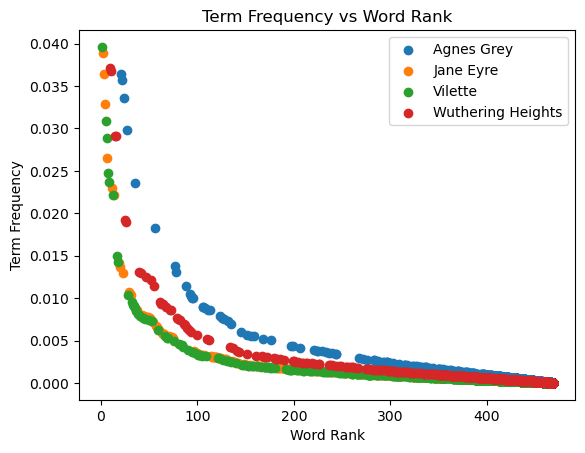

In [15]:
# Write your code below

# Uncomment below for Ex. 1.3.
import matplotlib.pyplot as plt

# # plot the data
for book, data in book_words_df.groupby("book"):
    plt.scatter(data["rank"], data["term_frequency"], label=book)

# # add labels and legend
plt.title("Term Frequency vs Word Rank")
plt.xlabel("Word Rank")
plt.ylabel("Term Frequency")
plt.legend()

### Excercise 2 - TF-IDF

1. Add a new idf column to your dataframe
2. Add the final tf-idf column to your dataframe
3. Display your dataframe's words in descending order of their tf-idf.

Idf or inverse document frequency is computed as **idf = log(N / n)**

where **N is the total number of documents (books)** in your dataset and **n is the number of documents containing the word**.

Once you have tf and idf, the tf-idf is obtained by simply multiplying the two.

Hint: For ex. 2.1 the pandas **transform** function could come in handy.

In [16]:
# Write your code below
import numpy as np


N = book_words_df['book'].nunique()
n = book_words_df['n'] = book_words_df.groupby('word')['book'].transform('nunique')
book_words_df['idf'] = np.log(N / n)
book_words_df = book_words_df.rename(columns={'n_x': 'total_no_of_books', 'n_y': 'no_of_word_freq'}) # Give more meaningful names

tf = book_words['term_frequency']
idf = book_words_df['idf']
book_words_df['tf-idf'] =  tf * idf

sorted_book_words = book_words_df.sort_values(by='tf-idf', ascending = False)
sorted_book_words.reset_index(drop = True, inplace = True)
sorted_book_words

,rank,word,book,word_appearances_in_book,book_total_word_count,term_frequency,n,idf,tf-idf
0,151.0,Heathcliff,Wuthering Heights,413,121114,0.003410,1,1.386294,0.004727
1,186.0,Linton,Wuthering Heights,340,121114,0.002807,1,1.386294,0.003892
2,198.0,Rochester,Jane Eyre,312,192766,0.001619,1,1.386294,0.002244
3,190.0,Catherine,Wuthering Heights,333,121114,0.002749,2,0.693147,0.001906
4,305.0,Hareton,Wuthering Heights,164,121114,0.001354,1,1.386294,0.001877
...,...,...,...,...,...,...,...,...,...
54097,437.0,With,Jane Eyre,32,192766,0.000166,4,0.000000,0.000000
54098,467.0,sentences,Wuthering Heights,2,121114,0.000017,4,0.000000,0.000000
54099,467.0,succeed,Wuthering Heights,2,121114,0.000017,4,0.000000,0.000000
54100,437.0,pleasant,Jane Eyre,32,192766,0.000166,4,0.000000,0.000000


# Language Models

A language model is a statistical model that can be used to estimate the probability of a sequence of words in a language. It is trained on a corpus of text data, and learns to predict the likelihood of observing a given sequence of words based on the frequency and context of those words in the training data.

Language models can be used for a variety of natural language processing tasks, such as text generation, machine translation, speech recognition, and more.

In [17]:
import nltk
from nltk.corpus import brown
from nltk import FreqDist
nltk.download('brown')

# load the Brown corpus
corpus = brown.words()

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In this example, we're using the Brown corpus from the nltk library, which is a collection of text samples from a wide range of genres, including news, fiction, and academic writing. 

In [18]:
print(corpus[1100:1110]) # Print a sample of 10 words from the corpus

['voters', '.', 'Despite', 'the', 'warning', ',', 'there', 'was', 'a', 'unanimous']


In [19]:
# create a frequency distribution of the words in the corpus
freq_dist = FreqDist(corpus)

# calculate the total number of words in the corpus
total_words = len(corpus)

# calculate the probability of each word in the corpus
word_probs = {word: freq_dist[word] / total_words for word in freq_dist.keys()}
print(word_probs['high']) # Probability of the word 'high' to appear

0.0003970058353829513


### Naive sentence generation

We're going to create a naive function that generates sentences using our language model.

In [20]:
# generate a sentence using the language model
import random

def generate_sentence(word_length = 10):
    sentence = []
    while len(sentence) < word_length:
        word = random.choices(list(word_probs.keys()), list(word_probs.values()))[0]
        sentence.append(word)
    return " ".join(sentence)

In [21]:
print(generate_sentence())

conversation protection of No. reason of from practice celebrated .


The sentences generated are likely not going to sound very good, since the model is extremely naive.

All that is happening is that each word in the sentence gets semi-randomly generated with the likelihood of it being chosen depending on its frequency in the Brown corpus.

# N-grams

So far we’ve considered words as individual units, and considered the relationship to their frequency of occurrence. However, many interesting text analyses are based on the relationships between words.
One such relationship is given by n-grams.

N-grams are groups of n consecutive words that appear in a given text corpus.

Bigrams are groups of 2 consecutive words (e.g. she went, he ate, car crashed)

Trigrams are groups of 3 consecutive words (e.g. she went home, he ate a, the car crashed).

In [22]:
# Example of what bigrams look like
bigrams = list(nltk.bigrams(corpus))
bigrams[:10]

[('The', 'Fulton'),
 ('Fulton', 'County'),
 ('County', 'Grand'),
 ('Grand', 'Jury'),
 ('Jury', 'said'),
 ('said', 'Friday'),
 ('Friday', 'an'),
 ('an', 'investigation'),
 ('investigation', 'of'),
 ('of', "Atlanta's")]

In [23]:
# Example of what trigrams look like
trigrams = list(nltk.trigrams(corpus))
trigrams[:10]

[('The', 'Fulton', 'County'),
 ('Fulton', 'County', 'Grand'),
 ('County', 'Grand', 'Jury'),
 ('Grand', 'Jury', 'said'),
 ('Jury', 'said', 'Friday'),
 ('said', 'Friday', 'an'),
 ('Friday', 'an', 'investigation'),
 ('an', 'investigation', 'of'),
 ('investigation', 'of', "Atlanta's"),
 ('of', "Atlanta's", 'recent')]

### Naive next word prediction

Knowing that word relations are pretty important in our language, let's create a function that predicts what the next word in a sentence would be using a simple **bigram** language model. 

In [24]:
from nltk.corpus import brown
import random

# get the words from the Brown corpus
corpus = brown.words()

# create bigrams from the corpus
bigrams = list(nltk.bigrams(corpus))

# calculate the frequency distribution of the bigrams
bigram_freqdist = nltk.FreqDist(bigrams)

# calculate the total number of bigrams in the corpus
total_bigrams = len(bigrams)

# create a function to generate the next word based on the previous word
def generate_next_word(sentence):
    prev_word = sentence.split()[-1]
    possible_words = {}
    for bigram in bigram_freqdist:
        if bigram[0] == prev_word:
            possible_words[bigram[1]] = bigram_freqdist[bigram] / total_bigrams
    if possible_words:
        return max(possible_words, key=possible_words.get)
    else:
        return None

In [25]:
# predict the next word for a given context
context = "The director"
next_word = generate_next_word(context)
print(f"The predicted next word for '{context}' is '{next_word}'")

The predicted next word for 'The director' is 'of'


### Exercise 3
1. Create a function that takes as input the number of words and generates a sentence using the previous bigram language model. You can start with a random first word from the brown corpus and then use generate_next_word(sentence) function to help you. 

2. Create a function that predicts the next word of a sentence by looking at the previous two words. This means you will create a trigram language model - use the same Brown corpus as before.

In [26]:
# Write your code below

from nltk.corpus import brown
import random

corpus = brown.words()
bigrams = list(nltk.bigrams(corpus))
bigram_freqdist = nltk.FreqDist(bigrams)

total_bigrams = len(bigrams)

# create a function to generate the next word based on the previous word
def generate_next_word(sentence):
    prev_word = sentence.split()[-1]
    possible_words = {}
    for bigram in bigram_freqdist:
        if bigram[0] == prev_word:
            possible_words[bigram[1]] = bigram_freqdist[bigram] / total_bigrams
    if possible_words:
        next_word = max(possible_words, key=possible_words.get)
        return next_word
    else:
        return None
            
def generate_sentence(no_of_words):
    first_word = random.choice(corpus)
    sentence = [first_word]
    
    for _ in range(no_of_words - 1):
        prev_word = sentence[-1]
        next_word = generate_next_word(prev_word)
        if next_word:
            sentence.append(next_word)
        else:
            break
            
    return ' '.join(sentence)
    
print(generate_sentence(6))
        
        


in the same time , and


### N-grams in dataframes

Let's get back to our books.
We'll create a dataframe containing information about the bigrams in our books corpus.


In [27]:
# The simplest way to do this would be to create the dataframe directly from bigrams rather than unigrams (single words)
import nltk
nltk.download('punkt')

bronte1_bigrams = list(nltk.bigrams(nltk.word_tokenize(bronte1)))
bronte1_df = pd.DataFrame(bronte1_bigrams, columns=['Word 1', 'Word 2'])

bronte2_bigrams = list(nltk.bigrams(nltk.word_tokenize(bronte2)))
bronte2_df = pd.DataFrame(bronte2_bigrams, columns=['Word 1', 'Word 2'])

bronte3_bigrams = list(nltk.bigrams(nltk.word_tokenize(bronte3)))
bronte3_df = pd.DataFrame(bronte3_bigrams, columns=['Word 1', 'Word 2'])

bronte4_bigrams = list(nltk.bigrams(nltk.word_tokenize(bronte4)))
bronte4_df = pd.DataFrame(bronte4_bigrams, columns=['Word 1', 'Word 2'])


# We’ll want to know which content comes from which book
bronte1_df = bronte1_df.assign(book = 'Jane Eyre')
bronte2_df = bronte2_df.assign(book = 'Wuthering Heights')
bronte3_df = bronte3_df.assign(book = 'Vilette')
bronte4_df = bronte4_df.assign(book = 'Agnes Grey')

# Finally, we concatenate the books into one dataframe
books = [bronte1_df, bronte2_df, bronte3_df, bronte4_df]
bronte_books_df = pd.concat(books)
bronte_books_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Word 1,Word 2,book
0,The,Project,Jane Eyre
1,Project,Gutenberg,Jane Eyre
2,Gutenberg,eBook,Jane Eyre
3,eBook,of,Jane Eyre
4,of,Jane,Jane Eyre


### Exercise 4

1. Add a **bigram** column that shows the entire bigrams ("The Project" and "Project Gutenberg" are examples of this column's values), not just the separate words.
2. Clean the dataframe by removing stop words.
3. Display the most frequently occuring 10 bigrams.

In [28]:
# Write your code below
from nltk.corpus import stopwords
nltk.download('stopwords')

print('1')
bronte_books_df['bigram'] = bronte_books_df['Word 1'] + ' ' + bronte_books_df['Word 2']
bronte_books_df.head()


1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Word 1,Word 2,book,bigram
0,The,Project,Jane Eyre,The Project
1,Project,Gutenberg,Jane Eyre,Project Gutenberg
2,Gutenberg,eBook,Jane Eyre,Gutenberg eBook
3,eBook,of,Jane Eyre,eBook of
4,of,Jane,Jane Eyre,of Jane


In [29]:
print('2')

english_stopwords = stopwords.words('english')
bronte_books_df = bronte_books_df[~bronte_books_df['bigram'].isin(english_stopwords)]
bronte_books_df


2


,Word 1,Word 2,book,bigram
0,The,Project,Jane Eyre,The Project
1,Project,Gutenberg,Jane Eyre,Project Gutenberg
2,Gutenberg,eBook,Jane Eyre,Gutenberg eBook
3,eBook,of,Jane Eyre,eBook of
4,of,Jane,Jane Eyre,of Jane
...,...,...,...,...
70908,newsletter,to,Agnes Grey,newsletter to
70909,to,hear,Agnes Grey,to hear
70910,hear,about,Agnes Grey,hear about
70911,about,new,Agnes Grey,about new


In [30]:
print('3')
occurences = list()
for word, count in bronte_books_df['bigram'].value_counts().items():
    if count == 10:
        occurences.append(word)
print(occurences)

3
['good for', 'things that', 'speak truth', 'me without', 'tell what', 'and come', 'all very', 'he demanded', 'of whose', 'hills and', 'could she', 'made you', 'To my', 'put up', 'open it', 'by what', 'that might', 'Gutenberg eBooks', 'the aid', 'to inform', 'by Mrs', 'sat at', 'bell rang', 'lost the', 'was both', 'one can', 'I trembled', 'promise to', 'band of', 'Grange I', 'as strong', 'both in', 'a grave', 'owns a', 'the privilege', 'the act', 'I so', 'a ghost', 'thought a', 'my pocket', 'return the', 'hear her', 'that did', 'manage to', 'or he', 'into it', 'my hopes', 'one is', 'and help', 'pang of', 'still less', 'forgot to', 'house with', 'are they', 'some weeks', 'Ah you', 'much too', 'she only', 'fact of', 'stranger to', 'a mans', 'I leave', 'me is', 'the ceiling', 'finger and', 'between two', 'wrong to', 'the post', 'in upon', 'two miles', 'you What', 'has done', 'because they', 'was cold', 'have already', 'an excellent', 'a trifle', 'and watch', 'was some', 'at church', 'be 

### Exercise 5

1. Create a dataframe containing the **bigram, word1, word2** and **book** columns for the following 4 books and remove stop words:
        https://www.gutenberg.org/cache/epub/1228/pg1228.txt - On the Origin of Species, by Charles Darwin

        https://www.gutenberg.org/cache/epub/4363/pg4363.txt - Beyond Good and Evil, by Friedrich Nietzsche

        https://www.gutenberg.org/cache/epub/3296/pg3296.txt - The Confessions of Saint Augustine, by Saint Augustine

        https://www.gutenberg.org/files/1661/1661-0.txt - The Adventures of Sherlock Holmes, by Arthur Conan Doyle

2. Display the most frequent 8 words of each book (use word1 column when counting)

3. Display the most relevant 8 words of each book based on tf-idf (use word1 column when counting)

4. Display the most relevant 5 bigrams of each book based on tf-idf

5. Display the most frequent 5 street names found in the entire 4 book corpus. The book they are coming from should also be visible.

6. Choose a fixed word1 of your choice and find the most common 5 bigrams in each book that have word1 equal to the word you chose.




In [31]:
# Write your code below

import requests
import string
import pandas as pd
import nltk
nltk.download('punkt')

print('1')
# On the Origin of Species, by Charles Darwin
book_url = 'https://www.gutenberg.org/cache/epub/1228/pg1228.txt'
response = requests.get(book_url)
on_the_origin_of_species = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
on_the_origin_of_species = ''.join(c for c in on_the_origin_of_species if c in allowed_chars)

print(on_the_origin_of_species[:5000])

# Beyond Good and Evil, by Friedrich Nietzsche
book_url = 'https://www.gutenberg.org/cache/epub/4363/pg4363.txt'
response = requests.get(book_url)
beyond_good_evil = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
beyond_good_evil = ''.join(c for c in beyond_good_evil if c in allowed_chars)

print(beyond_good_evil[:5000])

# The Confessions of Saint Augustine, by Saint Augustine
book_url = ' https://www.gutenberg.org/cache/epub/3296/pg3296.txt'
response = requests.get(book_url)
the_confessions_of_saint_augustine = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
the_confessions_of_saint_augustine = ''.join(c for c in the_confessions_of_saint_augustine if c in allowed_chars)

print(the_confessions_of_saint_augustine[:5000])

# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
book_url = 'https://www.gutenberg.org/files/1661/1661-0.txt'
response = requests.get(book_url)
the_adventures_of_sherlock_holmes = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
the_adventures_of_sherlock_holmes = ''.join(c for c in the_adventures_of_sherlock_holmes if c in allowed_chars)

print(the_adventures_of_sherlock_holmes[:5000])

# Creating dataframes
on_the_origin_of_species_lines = on_the_origin_of_species.splitlines()
on_the_origin_of_species_df = pd.DataFrame({
    "line": on_the_origin_of_species_lines,
    "line_number": list(range(len(on_the_origin_of_species_lines)))
})

beyond_good_evil_lines = beyond_good_evil.splitlines()
beyond_good_evil_df = pd.DataFrame({
    "line": beyond_good_evil_lines,
    "line_number": list(range(len(beyond_good_evil_lines)))
})

the_confessions_of_saint_augustine_lines = the_confessions_of_saint_augustine.splitlines()
the_confessions_of_saint_augustine_df = pd.DataFrame({
    "line": the_confessions_of_saint_augustine_lines,
    "line_number": list(range(len(the_confessions_of_saint_augustine_lines)))
})

the_adventures_of_sherlock_holmes_lines = the_adventures_of_sherlock_holmes.splitlines()
the_adventures_of_sherlock_holmes_df = pd.DataFrame({
    "line": the_adventures_of_sherlock_holmes_lines,
    "line_number": list(range(len(the_adventures_of_sherlock_holmes_lines)))
})

# Tokenizing the data 
on_the_origin_of_species_bigrams = list(nltk.bigrams(nltk.word_tokenize(on_the_origin_of_species)))
on_the_origin_of_species_df = pd.DataFrame(on_the_origin_of_species_bigrams, columns=['Word 1', 'Word 2'])

beyond_good_evil_bigrams = list(nltk.bigrams(nltk.word_tokenize(beyond_good_evil)))
beyond_good_evil_df = pd.DataFrame(beyond_good_evil_bigrams, columns=['Word 1', 'Word 2'])

the_confessions_of_saint_augustine_bigrams = list(nltk.bigrams(nltk.word_tokenize(the_confessions_of_saint_augustine)))
the_confessions_of_saint_augustine_df = pd.DataFrame(the_confessions_of_saint_augustine_bigrams, columns=['Word 1', 'Word 2'])

the_adventures_of_sherlock_holmes_bigrams = list(nltk.bigrams(nltk.word_tokenize(the_adventures_of_sherlock_holmes)))
the_adventures_of_sherlock_holmes_df = pd.DataFrame(the_adventures_of_sherlock_holmes_bigrams, columns=['Word 1', 'Word 2'])



# Assigning the name to each book
on_the_origin_of_species_df = on_the_origin_of_species_df.assign(book='On the Origin of Species')
beyond_good_evil_df = beyond_good_evil_df.assign(book='Beyond Good and Evil')
the_confessions_of_saint_augustine_df = the_confessions_of_saint_augustine_df.assign(book='The Confessions of Saint Augustine')
the_adventures_of_sherlock_holmes_df = the_adventures_of_sherlock_holmes_df.assign(book='The Adventures of Sherlock Holmes')

books = [on_the_origin_of_species_df, beyond_good_evil_df, the_confessions_of_saint_augustine_df, the_adventures_of_sherlock_holmes_df]
four_author_books_df = pd.concat(books)
four_author_books_df.head()

four_author_books_df['bigram'] = four_author_books_df['Word 1'] + ' ' + four_author_books_df['Word 2']
four_author_books_df.head()


1


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The Project Gutenberg eBook of On the Origin of Species By Means of Natural Selection
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever You may copy it give it away or reuse it under the terms
of the Project Gutenberg License included with this ebook or online
at wwwgutenbergorg If you are not located in the United States
you will have to check the laws of the country where you are located
before using this eBook

Title On the Origin of Species By Means of Natural Selection

Author Charles Darwin

Release date March 1 1998 eBook 1228
                Most recently updated October 28 2023

Language English

Credits Sue Asscher and David Widger


 START OF THE PROJECT GUTENBERG EBOOK ON THE ORIGIN OF SPECIES BY MEANS OF NATURAL SELECTION 




There are several editions of this ebook in the Project Gutenberg collection
Various characteristics of each ebook are listed to aid in selec

,Word 1,Word 2,book,bigram
0,The,Project,On the Origin of Species,The Project
1,Project,Gutenberg,On the Origin of Species,Project Gutenberg
2,Gutenberg,eBook,On the Origin of Species,Gutenberg eBook
3,eBook,of,On the Origin of Species,eBook of
4,of,On,On the Origin of Species,of On


In [32]:
print('2')
occurences = four_author_books_df[four_author_books_df['Word 1'].map(four_author_books_df['Word 1'].value_counts()) == 8]['Word 1'].tolist()
print(occurences)


2
['Means', 'restrictions', 'reuse', 'Means', 'START', 'EBOOK', 'NATURAL', 'file', 'NATURAL', 'World', 'NATURAL', '7', '9', 'distinguishing', 'Struggle', 'NATURAL', 'Sexual', 'lowly', 'Means', 'non', 'facit', 'saltum', '7', 'Sterility', 'Sterility', 'Hybrids', '9', 'Means', 'fifteen', 'Struggle', 'kingdoms', 'distinguishing', 'treatment', 'treatment', 'tame', 'sets', 'copious', 'Sterility', 'treatment', 'treatment', 'larva', 'cats', 'breeder', 'viewing', 'caterpillar', 'boldly', 'Whether', 'assert', 'poultry', 'uniformity', 'competent', 'competent', 'endurance', 'competent', 'poultry', 'kingdoms', 'expressly', 'nostrils', 'heels', 'pouter', 'tailfeathers', 'vertebr', 'nostrils', 'remarkably', 'pouter', 'pouter', 'pouter', 'tailfeathers', 'tailfeathers', 'tailfeathers', 'firstly', 'carriers', 'firstly', 'tailfeathers', 'bill', 'poultry', 'breeder', 'bold', 'host', 'devoted', 'competent', 'acquainted', 'skilful', 'breeder', 'breeder', 'requisite', 'skilful', 'pick', 'objected', 'methodic

In [33]:
four_author_books_df.groupby(['Word 1']).size().sort_values(ascending=False).reset_index(name='count')
four_author_books_df.groupby(['Word 1', 'book']).size().sort_values(ascending=False).reset_index(name='count')
four_author_books_df

,Word 1,Word 2,book,bigram
0,The,Project,On the Origin of Species,The Project
1,Project,Gutenberg,On the Origin of Species,Project Gutenberg
2,Gutenberg,eBook,On the Origin of Species,Gutenberg eBook
3,eBook,of,On the Origin of Species,eBook of
4,of,On,On the Origin of Species,of On
...,...,...,...,...
107559,newsletter,to,The Adventures of Sherlock Holmes,newsletter to
107560,to,hear,The Adventures of Sherlock Holmes,to hear
107561,hear,about,The Adventures of Sherlock Holmes,hear about
107562,about,new,The Adventures of Sherlock Holmes,about new


In [34]:
# We group our data by words, then we aggregate and can decide what information we want to display for each column

# setting 'first' for the book column means that in the new dataframe we will display the first book on which each word occurs (in the book column)
# setting 'count' for the word column means that in the new dataframe we will display the count of given word (in the word column)
count_df = four_author_books_df.groupby('Word 1').agg({'book': 'first', 'Word 1': 'count'}) 
count_df

,book,Word 1
Word 1,,
1,On the Origin of Species,15
10,On the Origin of Species,7
100,On the Origin of Species,7
1000,On the Origin of Species,9
101,On the Origin of Species,5
...,...,...
zoneit,Beyond Good and Evil,1
zones,On the Origin of Species,12
zoological,On the Origin of Species,1


In [35]:
count_df = count_df.rename(columns={'Word 1': 'count'})
count_df.sort_values('count', ascending=False)

,book,count
Word 1,,
the,On the Origin of Species,23748
of,On the Origin of Species,17019
and,On the Origin of Species,14160
to,On the Origin of Species,11222
in,On the Origin of Species,8725
...,...,...
interstices,On the Origin of Species,1
Samos,Beyond Good and Evil,1
intervalsindispensable,On the Origin of Species,1


In [36]:
count_df_1 = four_author_books_df.groupby(['Word 1', 'book']).size().sort_values(ascending=False).reset_index(name='count') # How many appearances each word has in each book
count_df_1

,Word 1,book,count
0,the,On the Origin of Species,10018
1,of,On the Origin of Species,7938
2,the,The Adventures of Sherlock Holmes,5425
3,the,The Confessions of Saint Augustine,4589
4,and,On the Origin of Species,4419
...,...,...,...
37452,modificationthe,On the Origin of Species,1
37453,modificationsnamely,Beyond Good and Evil,1
37454,modificationseach,On the Origin of Species,1
37455,modificationfor,On the Origin of Species,1


In [37]:
count_df_2 = four_author_books_df.groupby(['book']).size().sort_values(ascending=False).reset_index(name='count') # How many words each book has
count_df_2

,book,count
0,On the Origin of Species,158706
1,The Confessions of Saint Augustine,114926
2,The Adventures of Sherlock Holmes,107564
3,Beyond Good and Evil,65749


In [38]:
book_words = count_df_1.merge(count_df_2, on='book')
book_words = book_words.rename(columns={'count_x': 'word_appearances_in_book', 'count_y': 'book_total_word_count'}) # Give more meaningful names
book_words.head(10)

,Word 1,book,word_appearances_in_book,book_total_word_count
0,the,On the Origin of Species,10018,158706
1,of,On the Origin of Species,7938,158706
2,and,On the Origin of Species,4419,158706
3,in,On the Origin of Species,3816,158706
4,to,On the Origin of Species,3652,158706
5,a,On the Origin of Species,2418,158706
6,that,On the Origin of Species,2051,158706
7,have,On the Origin of Species,1767,158706
8,be,On the Origin of Species,1671,158706
9,as,On the Origin of Species,1492,158706


In [39]:
book_words['term_frequency'] = book_words['word_appearances_in_book'].div(book_words['book_total_word_count'])
book_words.dropna(subset = ['term_frequency'], inplace=True)
book_words.head()


,Word 1,book,word_appearances_in_book,book_total_word_count,term_frequency
0,the,On the Origin of Species,10018,158706,0.063123
1,of,On the Origin of Species,7938,158706,0.050017
2,and,On the Origin of Species,4419,158706,0.027844
3,in,On the Origin of Species,3816,158706,0.024044
4,to,On the Origin of Species,3652,158706,0.023011


In [40]:
rank_df = book_words['word_appearances_in_book'].rank(method='dense', ascending=False)
book_words_df = pd.concat([rank_df.rename('rank'), book_words], axis=1).reset_index(drop=True)
book_words_df[['Word 1', 'book', 'word_appearances_in_book','book_total_word_count', 'term_frequency', 'rank']]

,Word 1,book,word_appearances_in_book,book_total_word_count,term_frequency,rank
0,the,On the Origin of Species,10018,158706,0.063123,1.0
1,of,On the Origin of Species,7938,158706,0.050017,2.0
2,and,On the Origin of Species,4419,158706,0.027844,5.0
3,in,On the Origin of Species,3816,158706,0.024044,7.0
4,to,On the Origin of Species,3652,158706,0.023011,9.0
...,...,...,...,...,...,...
37452,capo,Beyond Good and Evil,1,65749,0.000015,431.0
37453,modification,Beyond Good and Evil,1,65749,0.000015,431.0
37454,moles,Beyond Good and Evil,1,65749,0.000015,431.0
37455,candidly,Beyond Good and Evil,1,65749,0.000015,431.0


In [41]:
import numpy as np
N = book_words_df['book'].nunique()
n = book_words_df['n'] = book_words_df.groupby('Word 1')['book'].transform('nunique')
book_words_df['idf'] = np.log(N / n)
book_words_df = book_words_df.rename(columns={'n_x': 'total_no_of_books', 'n_y': 'no_of_word_freq'}) # Give more meaningful names

tf = book_words['term_frequency']
idf = book_words_df['idf']
book_words_df['tf-idf'] =  tf * idf
 

In [42]:

book_words_df.drop('book', axis = 1)

,rank,Word 1,word_appearances_in_book,book_total_word_count,term_frequency,n,idf,tf-idf
0,1.0,the,10018,158706,0.063123,4,0.000000,0.000000
1,2.0,of,7938,158706,0.050017,4,0.000000,0.000000
2,5.0,and,4419,158706,0.027844,4,0.000000,0.000000
3,7.0,in,3816,158706,0.024044,4,0.000000,0.000000
4,9.0,to,3652,158706,0.023011,4,0.000000,0.000000
...,...,...,...,...,...,...,...,...
37452,431.0,capo,1,65749,0.000015,1,1.386294,0.000021
37453,431.0,modification,1,65749,0.000015,4,0.000000,0.000000
37454,431.0,moles,1,65749,0.000015,2,0.693147,0.000011
37455,431.0,candidly,1,65749,0.000015,1,1.386294,0.000021


In [43]:

four_books_df = pd.concat([four_author_books_df, book_words],axis = 1)
four_books_df = four_books_df.dropna(axis=0)
four_books_df['n'] = book_words_df['n']
four_books_df['idf'] = book_words_df['idf']
four_books_df['tf-idf']= book_words_df['tf-idf']
four_books_df

sorted_df = four_books_df.sort_values(by= 'tf-idf', ascending = False)
sorted_df.reset_index(drop = True, inplace = True)

sorted_df = sorted_df.loc[:,~sorted_df.columns.duplicated()]
sorted_df

,Word 1,Word 2,book,bigram,word_appearances_in_book,book_total_word_count,term_frequency,n,idf,tf-idf
0,the,side,On the Origin of Species,the side,875.0,114926.0,0.007614,1,1.386294,0.010555
1,grief,for,The Confessions of Saint Augustine,grief for,875.0,114926.0,0.007614,1,1.386294,0.010555
2,observation,and,The Adventures of Sherlock Holmes,observation and,875.0,114926.0,0.007614,1,1.386294,0.010555
3,entire,University,Beyond Good and Evil,entire University,875.0,114926.0,0.007614,1,1.386294,0.010555
4,proportion,of,On the Origin of Species,proportion of,1005.0,114926.0,0.008745,2,0.693147,0.006061
...,...,...,...,...,...,...,...,...,...,...
149823,the,yet,The Confessions of Saint Augustine,the yet,1.0,158706.0,0.000006,4,0.000000,0.000000
149824,shoot,of,The Confessions of Saint Augustine,shoot of,1.0,158706.0,0.000006,4,0.000000,0.000000
149825,my,heart,The Confessions of Saint Augustine,my heart,1.0,158706.0,0.000006,4,0.000000,0.000000
149826,these,empty,The Confessions of Saint Augustine,these empty,1.0,158706.0,0.000006,4,0.000000,0.000000


In [44]:
print('3')

occurences = sorted_df.groupby('book').apply(lambda x : x.nlargest(8, 'tf-idf')['Word 1']).reset_index(drop=True)
occurences

3


0         entire
1             of
2          actor
3     University
4          ebook
         ...    
27           for
28          This
29            my
30           The
31        bodily
Name: Word 1, Length: 32, dtype: object

In [45]:
print('4')

occurrences_bigrams = sorted_df.groupby('book').apply(lambda x: x.nlargest(5, 'tf-idf')['bigram']).reset_index(drop=True)
occurrences_bigrams


4


0        entire University
1             of laborious
2              actor lurks
3     University personnel
4                 ebook is
              ...         
15               grief for
16                  But is
17            firmament to
18                   for a
19              This ebook
Name: bigram, Length: 20, dtype: object

In [46]:
new_df = sorted_df
new_df

,Word 1,Word 2,book,bigram,word_appearances_in_book,book_total_word_count,term_frequency,n,idf,tf-idf
0,the,side,On the Origin of Species,the side,875.0,114926.0,0.007614,1,1.386294,0.010555
1,grief,for,The Confessions of Saint Augustine,grief for,875.0,114926.0,0.007614,1,1.386294,0.010555
2,observation,and,The Adventures of Sherlock Holmes,observation and,875.0,114926.0,0.007614,1,1.386294,0.010555
3,entire,University,Beyond Good and Evil,entire University,875.0,114926.0,0.007614,1,1.386294,0.010555
4,proportion,of,On the Origin of Species,proportion of,1005.0,114926.0,0.008745,2,0.693147,0.006061
...,...,...,...,...,...,...,...,...,...,...
149823,the,yet,The Confessions of Saint Augustine,the yet,1.0,158706.0,0.000006,4,0.000000,0.000000
149824,shoot,of,The Confessions of Saint Augustine,shoot of,1.0,158706.0,0.000006,4,0.000000,0.000000
149825,my,heart,The Confessions of Saint Augustine,my heart,1.0,158706.0,0.000006,4,0.000000,0.000000
149826,these,empty,The Confessions of Saint Augustine,these empty,1.0,158706.0,0.000006,4,0.000000,0.000000


In [47]:
import pandas as pd
import re
import nltk


exploded_df = new_df.explode('bigram')

street_name_pattern = r'\b(?:\d+\s)?[A-Z][a-zA-Z]*\s(?:Street|Avenue|Road|Lane|Boulevard|Drive|Court|Place|Square|Terrace|Way|Parkway|Circle|Highway|Alley|Crescent|Plaza|Trail|Row|Path)\b'

exploded_df['potential_street_names'] = exploded_df['bigram'].apply(lambda x: re.findall(street_name_pattern, x))

exploded_df = exploded_df.explode('potential_street_names').dropna(subset=['potential_street_names'])

street_name_counts = exploded_df.groupby('potential_street_names').size().reset_index(name='count')

top_street_names = street_name_counts.nlargest(5, 'count')

top_street_names_with_books = pd.merge(top_street_names, exploded_df, on='potential_street_names')

result = top_street_names_with_books[['potential_street_names', 'book']].drop_duplicates()

print("Top 5 most frequent street names with the book they are coming from:")
result


Top 5 most frequent street names with the book they are coming from:


,potential_street_names,book
0,Baker Street,The Adventures of Sherlock Holmes
13,SaxeCoburg Square,The Adventures of Sherlock Holmes
19,Leadenhall Street,The Adventures of Sherlock Holmes
23,Popes Court,The Adventures of Sherlock Holmes
26,Serpentine Avenue,The Adventures of Sherlock Holmes


In [76]:
df = pd.DataFrame(data)

# Fixed word1
fixed_word1 = "observation"

# Filter bigrams where 'Word 1' is the fixed word
filtered_df = new_df[new_df['Word 1'] == fixed_word1]

# Group by book and bigram, then count the occurrences
grouped = filtered_df.groupby(['book', 'bigram']).size().reset_index(name='count')

# Get the top 5 most common bigrams for each book
top_bigrams = grouped.groupby('book').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Print the results
for book in top_bigrams['book'].unique():
    print(f"Top 5 bigrams in '{book}' with '{fixed_word1}' as the first word:")
    book_bigrams = top_bigrams[top_bigrams['book'] == book]
    for _, row in book_bigrams.iterrows():
        print(f"  ({row['bigram']}): {row['count']}")
    print()

Top 5 bigrams in 'The Adventures of Sherlock Holmes' with 'observation' as the first word:
  (observation and): 2
  (observation of): 2
  (observation in): 1
  (observation not): 1

Top 5 bigrams in 'The Confessions of Saint Augustine' with 'observation' as the first word:
  (observation amid): 1

